In [1]:
from __future__ import absolute_import, division, print_function

# !pip install -q tensorflow-gpu==2.0.0-alpha0
!pip install tf-nightly-2.0-preview

import tensorflow as tf
# import tensorflow.contrib.eager as tfe

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time


    100% |████████████████████████████████| 96.1MB 328kB/s 
    100% |████████████████████████████████| 3.0MB 10.5MB/s 
    100% |████████████████████████████████| 358kB 20.8MB/s 
    100% |████████████████████████████████| 61kB 25.0MB/s 


## 1. Preprocess the Data 'fra.txt'

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, FRENCH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [4]:
path_to_file = 'fra.txt'
en, fr = create_dataset(path_to_file, None)
print(en[1])
print(fr[1])

<start> hi . <end>
<start> salut ! <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)
  
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)
  
  tensor = lang_tokenizer.texts_to_sequences(lang)
  
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  
  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
# Experiment on 10000 samples from the dataset
num_samples = 10000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_samples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)



In [7]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print("input tensor length: {} target tensor length: {} input validation length:{} target validation length: {}".format(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)))


input tensor length: 8000 target tensor length: 8000 input validation length:2000 target validation length: 2000


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [9]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[3])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[3])

Input Language; index to word mapping
1 ----> <start>
4 ----> i
25 ----> can
27 ----> do
7 ----> it
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> je
75 ----> peux
17 ----> le
85 ----> faire
3 ----> .
2 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
latent_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [13]:
# Show the shape of the tensor
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 8]), TensorShape([64, 15]))

## 2.1 Encoder:
First embed the input words inside English sentence with 256 dimension of embedding, then pass into the one-layer LSTM with 1024 units. 

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, latent_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, latent_dim)
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                 return_sequences=True, 
                                 return_state=True)

  def call(self, x, hidden, cell):
    x = self.embedding(x)
    #Pass the embedding of x into LSTM
    outputs = self.lstm(x, initial_state=[hidden,cell]) 
    output = outputs[0]
    state = outputs[1:]
    return output, state[0], state[1]

  def initialize_hidden_state(self):
    return (tf.zeros((self.batch_sz, self.enc_units)),
            tf.zeros((self.batch_sz, self.enc_units)))

In [0]:
# Initializa the Encoder with input vocab size for the one-hot encoder of word index
encoder = Encoder(vocab_inp_size, latent_dim, units, BATCH_SIZE)

## 2.2 Decoder
First embed the decoder input word with 256 dimension vector embedding, then pass into another 1024-unit output LSTM. <br>
During the **training stage**, the input of the (t+1) LSTM hidden state is the gold (t+1)th word in the output sentence. The output has been padded with 'START' and 'END'. <br>
When run the evaluation on the **validation(test) dataset**, the input of t-th hidden state is taking the largest index from the softmax output of the (t-1)th hidden layer. Since the hidden state of the (t-1)th hidden layer is passed onto (t)-th hidden state, here I set return-state=True.


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, latent_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, latent_dim)
    self.lstm = tf.keras.layers.LSTM(self.dec_units, 
                                   return_sequences=True, 
                                   return_state=True,
                                     recurrent_initializer='glorot_uniform')
    #The decoder here doesn't use the softmax activation, however, in the optimization I used the from_logits=True
    #which takes the softmax from the output dense layer, and output the same dimension vector with sum=1
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden, cell):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # passing the embedded x into LSTM with encoder as initializer
    output, state, cell = self.lstm(x, initial_state=[hidden, cell])
    x = self.dense(output)
    return x, state, cell

In [0]:
decoder = Decoder(vocab_tar_size, latent_dim, units, BATCH_SIZE)

## 2.3 Loss Function
The loss function is the Categorical Crossentropy summed over all hidden state outputs of the decoder. <br>
$\text{from_logits=True}$ calculates the softmax from decoder dense layer output.

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 3.1 Training Step --- Teacher-forcing with the gold target as the next decoder's input.

In [0]:
def train_step(inp, targ, enc_hidden,enc_cell):
  loss = 0
  reg_lambda = 0.0008
  with tf.GradientTape() as tape:
    enc_output, enc_hidden, enc_cell = encoder(inp, enc_hidden, enc_cell)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)       

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      logits, dec_hidden, dec_cell = decoder(dec_input, dec_hidden, dec_cell)
      loss += loss_function(targ[:, t], logits)
      
  # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)
    
    variables = encoder.trainable_variables + decoder.trainable_variables
  # add regularization:
    for v in variables:
        loss += reg_lambda*tf.reduce_sum(tf.pow(v,2))
  batch_loss = (loss/int(targ.shape[1]))

  gradients = tape.gradient(loss, variables)
  
  optimizer.apply_gradients(zip(gradients, variables))
  
  return batch_loss

## 3.2 Test Step --- Run test on the validation every epoch.

In [0]:
def test_step(inp, targ, enc_hidden_test, enc_cell_test):
  loss = 0
  enc_output_test, enc_hidden_test, enc_cell_test = encoder(inp, enc_hidden_test, enc_cell_test)
  dec_hidden_test = enc_hidden_test
  dec_cell_test = enc_cell_test
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * input_tensor_val.shape[0], 1)
  
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    
    logits, dec_hidden_test, dec_cell_test = decoder(dec_input, dec_hidden_test, dec_cell_test)
    predicted_id = tf.argmax(logits,axis =-1).numpy()
    loss += loss_function(targ[:, t], logits)
    # using t-1 prediction as input for t
    dec_input = predicted_id
    
  test_loss = (loss/int(targ.shape[1]))
  return test_loss

**I have stored the checkpoint every 20 expochs in case the system disconnected during the training, as well as the training and test loss.** <br>

The following just provides the training and test loss for the last 40 epochs

In [26]:
EPOCHS = 100
train_loss_history = []
test_loss_history = []
from google.colab import files
for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden, enc_cell = encoder.initialize_hidden_state()
  total_loss = 0

#   if epoch%25==0 and epoch!=0:
#     learning_rate = learning_rate/(epoch//25+1)
#     print("-----------------------------------------------")
#     print(learning_rate)
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden, enc_cell)
    total_loss += batch_loss
    train_loss_history.append(batch_loss.numpy())
    
    if batch % 10 == 0:
        print('Epoch {} Batch {} TrainLoss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    
  enc_hidden_test = tf.zeros((input_tensor_val.shape[0], units))
  enc_cell_test = tf.zeros((input_tensor_val.shape[0], units))
  test_loss = test_step(tf.convert_to_tensor(input_tensor_val),
                       tf.convert_to_tensor(target_tensor_val),
                       enc_hidden_test, enc_cell_test)
  test_loss_history.append(test_loss.numpy())
  print('Epoch {} TestLoss {:.4f}'.format(epoch + 1, test_loss.numpy()))

  print('Epoch {} TrainLoss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 67 Batch 0 TrainLoss 0.6902
Epoch 67 Batch 10 TrainLoss 0.7668
Epoch 67 Batch 20 TrainLoss 0.8669
Epoch 67 Batch 30 TrainLoss 0.7762
Epoch 67 Batch 40 TrainLoss 0.7678
Epoch 67 Batch 50 TrainLoss 0.7658
Epoch 67 Batch 60 TrainLoss 0.7800
Epoch 67 Batch 70 TrainLoss 0.8018
Epoch 67 Batch 80 TrainLoss 0.7527
Epoch 67 Batch 90 TrainLoss 0.7505
Epoch 67 Batch 100 TrainLoss 0.8099
Epoch 67 Batch 110 TrainLoss 0.7751
Epoch 67 Batch 120 TrainLoss 0.7992
Epoch 67 TestLoss 1.0689
Epoch 67 TrainLoss 0.7931
Time taken for 1 epoch 461.2321517467499 sec

Epoch 68 Batch 0 TrainLoss 0.6759
Epoch 68 Batch 10 TrainLoss 0.6971
Epoch 68 Batch 20 TrainLoss 0.7392
Epoch 68 Batch 30 TrainLoss 0.6847
Epoch 68 Batch 40 TrainLoss 0.6794
Epoch 68 Batch 50 TrainLoss 0.6849
Epoch 68 Batch 60 TrainLoss 0.6818
Epoch 68 Batch 70 TrainLoss 0.6844
Epoch 68 Batch 80 TrainLoss 0.6534
Epoch 68 Batch 90 TrainLoss 0.6710
Epoch 68 Batch 100 TrainLoss 0.7133
Epoch 68 Batch 110 TrainLoss 0.6811
Epoch 68 Batch 120 TrainL

## 4.1 Evaluation Train Test Loss Plots

In [0]:
##Reload the training and test loss from the saved txt:
train_loss_history = []
test_loss_history = []
with open('100EpochLSTMResults.txt') as file:
  for line in file:
    line = line.strip()
    line = line.split()
    if len(line)>2:
      if line[-2]=='TrainLoss' and len(line)>4:
        train_loss_history.append(float(line[-1][:-1]))
      elif line[-2] == 'TestLoss':
        test_loss_history.append(float(line[-1][:-1]))

Text(0, 0.5, 'Training Loss')

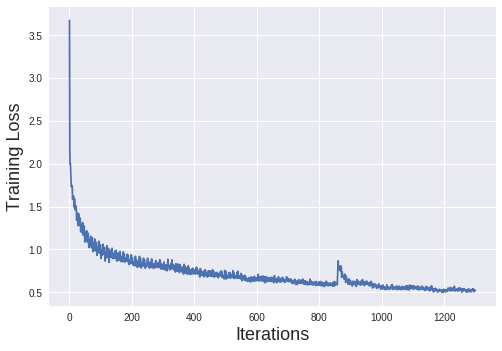

In [46]:
plt.plot(train_loss_history)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('Training Loss', fontsize=18)

Text(0, 0.5, 'Test Loss')

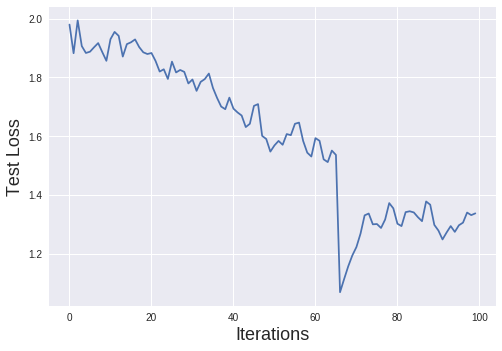

In [45]:
plt.plot(test_loss_history)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('Test Loss', fontsize=18)

## 4.2 Reload the checkpoint for quantitative evaluation
 **Translate the English into French **

In [47]:
## Restore the last saved checkpoint
checkpoint.restore('./ckpt-48')

In [0]:
def evaluate(sentence):    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], 
                                                           maxlen=max_length_inp, 
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden1 = tf.zeros((1, units))
    hidden2 = tf.zeros((1, units))
    enc_output, enc_hidden, enc_cell = encoder(inputs, hidden1, hidden2)

    dec_hidden, dec_cell = enc_hidden, enc_cell
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
      logits, dec_hidden,dec_cell = decoder(dec_input, dec_hidden,dec_cell)

      logits = tf.reshape(logits, (-1,logits.shape[2]))
      predicted_id = tf.argmax(logits[0]).numpy()
           

      result += targ_lang.index_word[predicted_id] + ' '

      if targ_lang.index_word[predicted_id] == '<end>':
        return result, sentence, dec_hidden#, attention_plot
        
        # the predicted ID is fed back into the model
      dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, dec_hidden

In [0]:
def translate(sentence):
    result,sentence,dec_hidden = evaluate(sentence)            
    print('Input: %s' % (sentence).encode('utf-8'))
    print('Predicted translation: {}'.format(result))
    return dec_hidden

In [86]:
sentences_Eng = [u'I want to be with Tom.', u'I want to be with you.',
                 u'I want to go with you.',
                u'I want to go to Tokyo.',
                u'I want to believe you.',
                u'I like this answer.']
pca_hidden = []
for sentence in sentences_Eng:
  dec_hidden = translate(sentence)
  pca_hidden.append(dec_hidden.numpy().reshape(1024,))
pca_hidden = np.asarray(pca_hidden)
print(pca_hidden.shape)

Input: b'<start> i want to be with tom . <end>'
Predicted translation: je veux une liste . <end> 
Input: b'<start> i want to be with you . <end>'
Predicted translation: je veux travailler . <end> 
Input: b'<start> i want to go with you . <end>'
Predicted translation: je veux venir . <end> 
Input: b'<start> i want to go to tokyo . <end>'
Predicted translation: je veux partir . <end> 
Input: b'<start> i want to believe you . <end>'
Predicted translation: je veux partir . <end> 
Input: b'<start> i like this answer . <end>'
Predicted translation: j aime ca . <end> 
(6, 1024)


In [109]:
translate(u'when do we eat ?')

Input: b'<start> when do we eat ? <end>'
Predicted translation: est ce les votres ? <end> 


<tf.Tensor: id=165968, shape=(1, 1024), dtype=float32, numpy=
array([[-0.10637847,  0.29853177,  0.5451261 , ...,  0.08465184,
        -0.677047  ,  0.03048863]], dtype=float32)>

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
hidden_transform = pca.fit(pca_hidden).transform(pca_hidden)

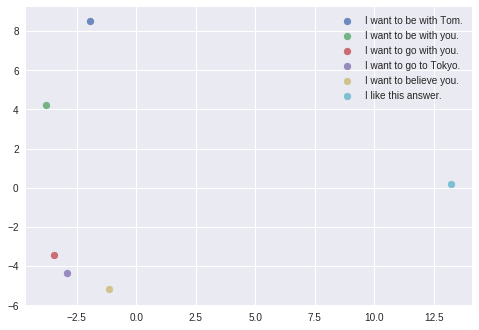

In [102]:
i=0
for x,y in hidden_transform:
    plt.scatter(x,y, alpha=.8, label=sentences_Eng[i])
    plt.legend()
    i+=1

As shown in the graph above, 'I want to go with you', 'I want to go to Tokyo' are very close to each other in the plot. 'I want to be with Tom ' and 'I want to be with you' are very close to each other. 'I like this answer' are semantically apart from the other five sentences. However, the translation is not that perfect as project 'I want to believe you' into a similar space as 'I want to go to Tokyo'.

In [36]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[6])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[6])

Input Language; index to word mapping
1 ----> <start>
679 ----> when
27 ----> do
12 ----> we
113 ----> eat
6 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
643 ----> quand
1378 ----> mangeons
11 ----> nous
7 ----> ?
2 ----> <end>


In [107]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[19])
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[19])


Input Language; index to word mapping
1 ----> <start>
12 ----> we
47 ----> all
68 ----> know
3 ----> .
2 ----> <end>
Target Language; index to word mapping
1 ----> <start>
11 ----> nous
17 ----> le
490 ----> savons
117 ----> toutes
3 ----> .
2 ----> <end>


### A few samples produced by LSTM ###

| **Type** |**Sentence**  |
|------|------|
|  **Input** |  '<start\> i ll marry you . <end\>'|
|   My model  | 'je vous epouserai . <end\>'|
|   Truth  |'<start\> je vous epouserai . <end\>' |
|  **Input** |  '<start\> you re lying ! <end\>'|
|   My model  | 'tu es ! <end\>'|
|   Truth  | '<start\> tu mens ! <end\>' |
|  **Input** |  '<start\> we all know . <end\>'|
|   My model  | 'nous le savons tous . <end\>'|
|   Truth  | '<start\> 'nous le savons toutes . <end\>' |
| **Input** |  '<start\> when do we eat ? <end\>'|
|   My model  | 'est ce les votres ? <end\>'|
|   Truth  | '<start\> 'quand mangeons nous ? <end\>' |
